Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 0.0208 - val_loss: 0.0095
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.0048 - val_loss: 0.0049
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


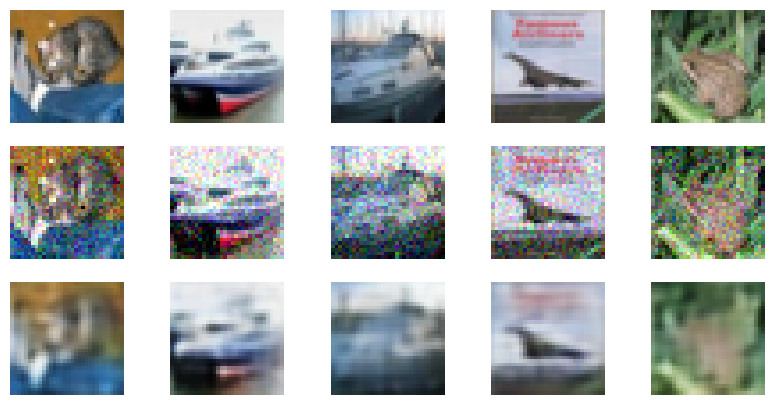

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar100
import cv2
import time

# Task 1: Image Quality Enhancement & Restoration using Autoencoder

def add_noise(img):
    noise = np.random.normal(0, 0.1, img.shape)
    img_noisy = img + noise
    return np.clip(img_noisy, 0, 1)

def add_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def preprocess_data(x):
    x = x.astype('float32') / 255.0  # Normalize
    x_noisy = np.array([add_noise(img) for img in x])
    x_blurry = np.array([add_blur(img) for img in x])
    return x, x_noisy, x_blurry

# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = tf.keras.datasets.cifar10.load_data()
X_train, X_train_noisy, X_train_blurry = preprocess_data(X_train)
X_test, X_test_noisy, X_test_blurry = preprocess_data(X_test)

def build_autoencoder():
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train autoencoder
history = autoencoder.fit(X_train_noisy, X_train, epochs=10, batch_size=64, validation_data=(X_test_noisy, X_test))

# Evaluate restoration
restored_images = autoencoder.predict(X_test_noisy)

def show_images(original, noisy, restored, num=5):
    plt.figure(figsize=(10, 5))
    for i in range(num):
        plt.subplot(3, num, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.subplot(3, num, i + 1 + num)
        plt.imshow(noisy[i])
        plt.axis('off')
        plt.subplot(3, num, i + 1 + num * 2)
        plt.imshow(restored[i])
        plt.axis('off')
    plt.show()

show_images(X_test, X_test_noisy, restored_images)


In [3]:
# Task 2: Image Classification using AlexNet & VGG16

def load_cifar100():
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize
    y_train, y_test = tf.keras.utils.to_categorical(y_train, 100), tf.keras.utils.to_categorical(y_test, 100)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar100()

# Load Pretrained Models
alexnet = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

def build_model(base_model):
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(100, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

alexnet_model = build_model(alexnet)
vgg16_model = build_model(vgg16)

# Training models
start = time.time()
alexnet_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
alexnet_time = time.time() - start

start = time.time()
vgg16_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
vgg16_time = time.time() - start

# Evaluate models
alexnet_acc = alexnet_model.evaluate(X_test, y_test)[1]
vgg16_acc = vgg16_model.evaluate(X_test, y_test)[1]

print(f"AlexNet Accuracy: {alexnet_acc:.4f}, Time Taken: {alexnet_time:.2f} sec")
print(f"VGG16 Accuracy: {vgg16_acc:.4f}, Time Taken: {vgg16_time:.2f} sec")

C:\Users\Anika Sharma\AppData\Local\Temp\ipykernel_13868\1647411617.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  alexnet = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - accuracy: 0.1244 - loss: 3.9105 - val_accuracy: 0.0170 - val_loss: 9.4757
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 130s 166ms/step - accuracy: 0.3009 - loss: 2.7094 - val_accuracy: 0.1443 - val_loss: 4.5929
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 164ms/step - accuracy: 0.3560 - loss: 2.4336 - val_accuracy: 0.0950 - val_loss: 4.6782
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 129s 165ms/step - accuracy: 0.3734 - loss: 2.3888 - val_accuracy: 0.2508 - val_loss: 3.3952
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 174ms/step - accuracy: 0.4174 - loss: 2.1540 - val_accuracy: 0.2705 - val_loss: 3.3892
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 303s 385ms/step - accuracy: 0.0239 - loss: 4.4080 - val_accuracy: 0.0554 - val_loss: 4.0020
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 313s 400ms/step - accuracy: 0.0621 - loss: 3.9598 - val_accuracy: 0.0840 - val_loss: 3.8012
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 380s 486ms/step - accuracy: 0.0927 - loss: 3